# Analisis de datos 

__En la primer casilla se vuelcan los datos y se hacen los import necesarios__

__Es necesario ejecutarla para poder hacer el resto__




In [2]:
import os
import pandas as pd
import datetime
import random
from matplotlib import pyplot as plt
%matplotlib inline

registro = os.path.join(os.getcwd(), "data", "log_de_partidas.csv")

data_set = pd.read_csv(registro, encoding="utf-8")

# Definiciones de las funciones:
__tambien hay que ejecutar esto para que ande todo__

In [3]:
def dibujito_torta(etiquetas, datos_dibujo, titulo, explota = (0.1), bbox = (1.2, 0.9)):
    """
        Hace un dibujo tipo torta con los datos que le pasas
        bbox es para que la leyenda no te tape los datos
    """
    explode = tuple([explota for x in datos_dibujo])

    plt.pie(datos_dibujo, explode=explode, labels=etiquetas, autopct='%1.2f%%',
    shadow=True, startangle=90, labeldistance= 1.1)

    plt.axis('equal')
    plt.legend(etiquetas, loc=1, bbox_to_anchor=bbox)
    plt.title(titulo)
    plt.show()

def dibujito_barra(llaves, valores, titulo, size = (6,6), prcnt = ""):
    """
       hace un grafico tipo bar con los valores
       tiene opcion para pasarle si queres que diga el % al final
       modifica varias cosas de posicionamiento porque sino salen los datos mal ubicados y no se ven
    """
    colores = [
            "Red", "Orange", "Purple", "Pink",
            "Yellow", "Blue", "Green", "bisque",
            "aqua", "magenta", "peru", "firebrick",
            "sienna", "gold", "deeppink"
          ]
    plt.figure(figsize=size)
    lista_colores = [random.choice(colores) for i in llaves]                  
    graph = plt.bar(llaves, valores, color = lista_colores)
    plt.title(titulo)
    i = 0
    for p in graph:
        width = p.get_width()
        height = p.get_height()
        x, y = p.get_xy()
        plt.text(x+width/2,
                 y+height*1.01,
                 str(list(valores)[i]) +prcnt,
                 ha='center',
                 weight='bold')
        i += 1
    plt.show()
    
def sacar_tiempo(inicio, fin):
    """quedó de la beta del analisis, pero ahorra como 2 lineas de codigo"""
    respuesta = pd.Timedelta(fin - inicio).total_seconds()
    
    return (str(datetime.timedelta(seconds=respuesta)))

## 1) Top 10 primeras palabras que se encuentran en las partidas:

# no se me ocurrio una mejor manera, se escuchan sugerencias.

# falta contarlas, pero tambien faltan los datos.

1. Saca todos los datos que no importan.
<br><br>
2. Itera para sacar el 1er "ok" de cada partida.
<br><br>
3. Usamos el evento "inicio_partida" para separarlas.

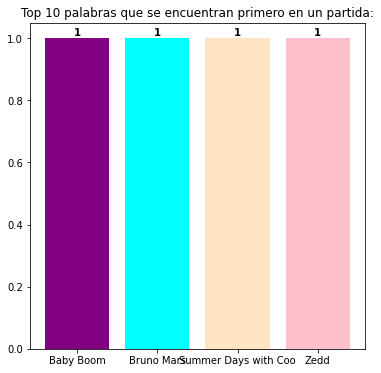

In [4]:
data_frame = data_set.drop(["timestamp", "id", "usuarie", "texto_ingresado", "nivel"], axis="columns")
data_frame = data_frame.drop(data_frame[data_frame.estado == "error"].index)
data_frame = data_frame.drop(data_frame[data_frame.estado == "timeout"].index)

nueva = True
lista_palabras = []

for row in data_frame.itertuples():
    evento = getattr(row, "evento")
    estado = getattr(row, "estado")
    if evento == "inicio_partida":
        nueva = True
    if nueva and estado == "ok":
        lista_palabras.append(getattr(row, "respuesta"))
        nueva = False

df_new = pd.DataFrame(lista_palabras, columns=["Palabras"])
serie = df_new.groupby("Palabras").size()
serie = serie.sort_values(ascending=False).head(10)

dibujito_barra(serie.index, serie.values, "Top 10 palabras que se encuentran primero en un partida:")

## 2) Grafico de partidas finalizadas por estado:

__pido perdon por ese for__

1. remuevo lo posible del data frame
<br><br>
2. itero sobre el resto porque no se me ocurre otra forma de contar las partidas sin evento fin
<br><br>
3. saco el resto de valores directo del dataframe y se los paso al dibujo
<br><br>
4. elegí pasar los tipos de partida que no tienen ocurrencias, pero se ven raro

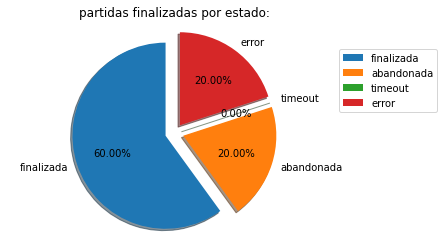

In [184]:
df = data_set.loc[:, ["evento", "estado"]]
df = df.drop(df[df.evento == "intento"].index)

cant_error = 0
nueva = False

for row in df.itertuples():
    evento = getattr(row, "evento")
    if nueva and evento == "inicio_partida":
        cant_error += 1
    elif evento == "inicio_partida":
        nueva = True
    elif evento == "fin":
        nueva = False
if nueva:
    cant_error += 1

df = df[df["evento"] == "fin"]
df = df.groupby(["estado"]).size()

etiquetas = ["finalizada", "abandonada", "timeout", "error"]

datos_dibujo = []
for key in etiquetas[:-1]:
    datos_dibujo.append(df[key] if key in df.index else 0)
datos_dibujo.append(cant_error)

dibujito_torta(etiquetas, datos_dibujo, "partidas finalizadas por estado:", bbox=(1.3, 0.9))

## 3) Grafico de partidas finalizadas segun genero:

# acordate de meter un metodo en perfiles para no romper encapsulamiento

1. pido los datos de los usuarios, para poder hacer la conexion nombre/genero.
<br><br> 
2. separo todos los eventos de fin.
<br><br>
3. enmascaro los datos para cambiar nombre por el genero autopercibido.
<br><br>
4. paso los datos a la figurita.

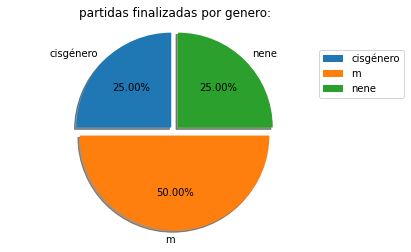

In [182]:
from json import load as jload
from jugadores import carga_analisy as cargar

usuarios = cargar()
    
df = data_set[data_set["evento"] == "fin"]
# Si no hago la copia me tira un cartelito rojo
df1 = df.copy()
df1["usuarie"]= df["usuarie"].apply(lambda x: usuarios[x][1] if x in usuarios.keys() else "indeterminado")

nuevo = df1.groupby(["usuarie"]).size()

etiquetas = nuevo.index.unique()
etiquetas = list(etiquetas)

datos_dibujo = []
for key in etiquetas:
    datos_dibujo.append(nuevo[key])

dibujito_torta(etiquetas, datos_dibujo, "partidas finalizadas por genero:", (0.05))

## 4) Grafico de las partidas finalizadas segun nivel:

__me quedó la duda de si poner en el grafico las dificultades que no tienen partida ó no__

__las terminé agregando__

1. separo las partidas que finalizaron.
<br><br>
2. las agrupo por nivel y mando al grafico.

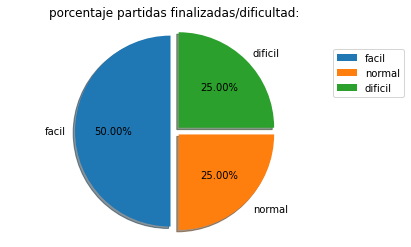

In [181]:
df = data_set[data_set["evento"] == "fin"]
df = df.groupby(["nivel"]).size()

etiquetas = ["facil", "normal", "dificil"]

datos_dibujo = []
for key in etiquetas:
    datos_dibujo.append(df[key] if key in df.index else 0)

dibujito_torta(etiquetas, datos_dibujo, "porcentaje partidas finalizadas/dificultad:", (0.05))

## 5) Duracion total de la partida:

### nunca se me termino de ocurrir como hacer esto y que quede bien

1. dejo solo los inicios/fin de partida del data frame
<br><br>
2. itero sobre la estructura sacando la diferencia de tiempo entre los 2 eventos(inicio y fin)
<br><br>
3. a la lista resultante le saco los valores naT y la paso a datetime porque sino no funciona el grafico
<br><br>
4. y la idea del grafico es que se muestre la duracion de las partidas a traves del tiempo, pero no se entiende nada

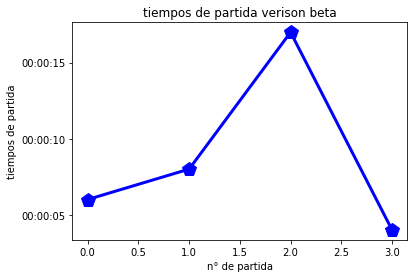

In [192]:
df = data_set.drop(data_set[data_set.evento == "intento"].index)
df.timestamp = df.timestamp.apply(lambda x: pd.Timestamp(x, unit='s'))

tempo = 0
partida = True
lista = []

for index, row in df.iterrows():
    if row["evento"] == "inicio_partida":
        tempo = row["timestamp"]
        partida = True
    elif row["evento"] == "fin" and partida:
        lista.append(sacar_tiempo(tempo,row["timestamp"]))
        partida = False

lista = [x for x in lista if x]
lista = list(map(lambda x: pd.to_datetime(x.split(".")[0], format= "%H:%M:%S"), lista))

x = [i for i in range(len(lista))]
y = lista

plt.xlabel("n° de partida")
plt.ylabel("tiempos de partida")
plt.title("tiempos de partida verison beta")
plt.plot(x, y, "-p", color='Blue', markersize=15, linewidth=3)

plt.show()

## 6) tiempo de la respuesta correcta mas rapida:

1. se sacan los elementos que no sirven
<br><br>
2. se cambian los timestamp por datetime
<br><br>
3. si itera agregando a una lista y se saca el minimo con min

In [190]:
data_frame = data_set.drop(["id", "usuarie", "texto_ingresado", "nivel"], axis="columns")
df = data_frame.drop(data_frame[data_frame.evento == "fin"].index)
df.timestamp = df.timestamp.apply(lambda x: pd.Timestamp(x, unit='s'))

anterior = 0
lista_tiempos = []

for index, row in df.iterrows():
    if anterior and row["estado"] == "ok":
        lista_tiempos.append(pd.Timedelta(row["timestamp"] - anterior).total_seconds())
    anterior = row["timestamp"]
    
minimo = min(lista_tiempos)

print(f"la respuesta correcta mas rapida se hizo en {minimo} segundos")

la respuesta correcta mas rapida se hizo en 0.917359 segundos


## 7) Promedio de tiempo de respuesta para respuestas correctas:

_lo mismo que el de arriba, pero sacando el promedio al final_

In [191]:
data_frame = data_set.drop(["id", "usuarie", "texto_ingresado", "nivel"], axis="columns")
df = data_frame.drop(data_frame[data_frame.evento == "fin"].index)
df.timestamp = df.timestamp.apply(lambda x: pd.Timestamp(x, unit='s'))

anterior = 0
lista_tiempos = []

for index, row in df.iterrows():
    if anterior and row["estado"] == "ok":
        lista_tiempos.append(pd.Timedelta(row["timestamp"] - anterior).total_seconds()) 
    anterior = row["timestamp"]
    
total = 0
for x in lista_tiempos:
    total += x
promedio = total / len(lista_tiempos)

print(f"Promedio de tiempo para respuesta correcta: {promedio} segundos")

Promedio de tiempo para respuesta correcta: 1.4680406666666668 segundos


## 8) Promedio de tiempo de partida general:

1. limpieza/acomode del data frame
<br><br>
2. itero sobre l oque queda para quedarme con los tiempos de inicio/fin de partida
<br><br>
3. se restan en sacar_tiempo y se agregan a una lista
<br><br>
4. de ahi saco un promedio

In [193]:
df = data_set.drop(data_set[data_set.evento == "intento"].index)
df.timestamp = df.timestamp.apply(lambda x: pd.Timestamp(x, unit='s'))

tempo = 0
partida = True
lista = []

for index, row in df.iterrows():
    if row["evento"] == "inicio_partida":
        tempo = row["timestamp"]
        partida = True
    elif row["evento"] == "fin" and partida:
        lista.append(sacar_tiempo(tempo,row["timestamp"]))
        partida = False

lista = [x for x in lista if x]
lista = list(map(lambda x: pd.Timedelta(x), lista))

average = 0
for date in lista:
    average += date.total_seconds()

prom = str(datetime.timedelta(seconds=average/len(lista))).split(":")

print("promedio de duracion general de partida: {} horas {} minutos {} segundos".format(prom[0], prom[1], prom[2]))

promedio de duracion general de partida: 0 horas 00 minutos 09.209529 segundos


## 9) Porcentaje de acierto por usuarie:

1. se limpia el data frame y se toman los valores de usuarie
<br><br>
2. agrupo los columnas relevantes y saco el promedio de cada usuarie
<br><br>
3. meto todo en un diccionario y al dibujo

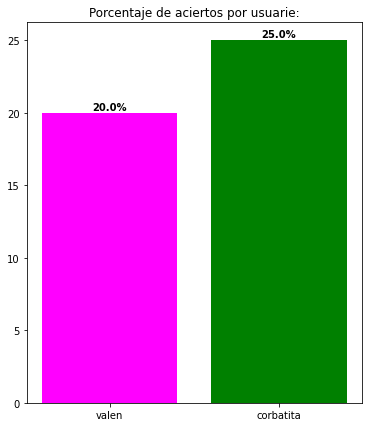

In [176]:
df = data_set.drop(data_set[data_set.evento != "intento"].index)
usuarios = data_set["usuarie"].unique()
nuevo = df.groupby(["usuarie", "estado"]).size()

result = {}

for nombre in usuarios:
    if nombre in nuevo and "ok" in nuevo[nombre].keys():
        aux = (nuevo[nombre].ok / nuevo[nombre].sum()) * 100
        result[nombre] = (round((aux), 2))
        
dibujito_barra(result.keys(), result.values(), "Porcentaje de aciertos por usuarie:", (6,7), "%")

## 10) Cantidad de tarjetas para las que el usuarie no dió respuesta (timeout):

_igual que el de arriba_

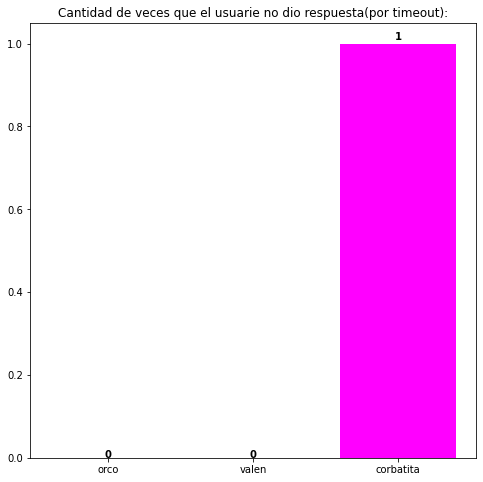

In [177]:
df = data_set.drop(data_set[data_set.evento != "intento"].index)
usuarios = data_set["usuarie"].unique()
df = df.drop(df[df.estado != "timeout"].index)
nuevo = df.groupby(["usuarie", "estado"]).size()

result = {}

for nombre in usuarios:
    if nombre in nuevo:
        result[nombre] = nuevo[nombre].timeout
    else:
        result[nombre] = 0
        
dibujito_barra(result.keys(), result.values(), "Cantidad de veces que el usuarie no dio respuesta(por timeout):", (8,8))

## 11) Cantidad de tarjetas en las que el usuarie dió una respuesta errónea:

_igual que los 2 anteriores_

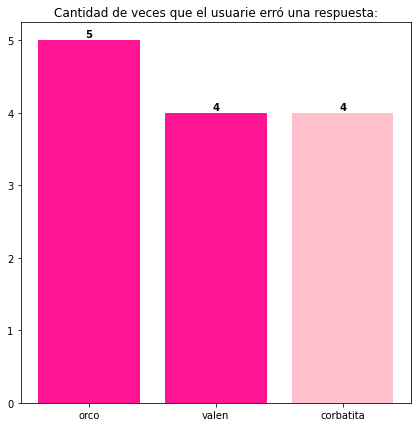

In [179]:
df = data_set.drop(data_set[data_set.evento != "intento"].index)
usuarios = data_set["usuarie"].unique()
df = df.drop(df[df.estado != "error"].index)
nuevo = df.groupby(["usuarie", "estado"]).size()

result = {}

for nombre in usuarios:
    if nombre in nuevo:
        result[nombre] = nuevo[nombre].error
    else:
        result[nombre] = 0
        
dibujito_barra(result.keys(), result.values(), "Cantidad de veces que el usuarie erró una respuesta:", (7,7))